In [ ]:

!git clone https://github.com/dmj6288/ESM_ProteinPred.git


Cloning into 'ESM_ProteinPred'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 12), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 636.38 KiB | 11.16 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
!cd /content/ESM_ProteinPred/

In [ ]:

!pip install --upgrade git+https://github.com/sokrypton/esm.git


  Cloning https://github.com/sokrypton/esm.git to /tmp/pip-req-build-vq40lfmp
  Running command git clone --filter=blob:none --quiet https://github.com/sokrypton/esm.git /tmp/pip-req-build-vq40lfmp
  Resolved https://github.com/sokrypton/esm.git to commit f6ef2277cd3e2b75ff4e4c8a8efa7457671ddb33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
!pip3 install torch torchaudio torchvision torchtext torchdata
# ESM isn't on pip/conda by default — clone from source
!pip install fair-esm
!pip install umap-learn biopython pandas scikit-learn matplotlib
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # PyTorch with CUDA 11.8


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [2]:
# Protein Embedding Project Skeleton
# Requirements: esm, pandas, scikit-learn, matplotlib, umap-learn

import torch
import esm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import umap
import numpy as np
import requests
import seaborn as sns
from Bio import SeqIO
from io import StringIO
from scipy.cluster.hierarchy import linkage, dendrogram


In [3]:
# === 1. Load lightweight ESM model ===
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()  # Smallest model
batch_converter = alphabet.get_batch_converter()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [5]:

# === 2. Define gene list and fetch UniProt FASTA sequences ===
genes = ['AQP4', 'SLC1A2', 'SLC4A4', 'GFAP', 'ALDH1L1', 'GJA1', 'GAD1', 'GAD2',
         'GRIK2', 'KCNC2', 'CDH9', 'KIT', 'SST', 'VIP', 'SV2C', 'SLC17A7', 'SATB2',
         'CAMK2A', 'CBLN2', 'IL1RAPL2', 'TRPM3', 'SEMA3E', 'SYT1', 'RBFOX3',
         'CUX2', 'RORB', 'TLE4', 'TYROBP', 'APBB1IP', 'P2RY12', 'CSF1R', 'CX3CR1',
         'PTPRC', 'DOCK8', 'HLA.DRA', 'OPALIN', 'MOBP', 'MBP', 'PLP1', 'ST18',
         'MOG', 'PDGFRA', 'PCDH15', 'VCAN', 'CSPG4']

species = {
    "human": 9606,
    "chimp": 9598,
    "macaque": 9544
}

base_url = "https://rest.uniprot.org/uniprotkb/stream"
all_embeddings = {sp: {} for sp in species}
MAX_LEN = 512

for sp_name, tax_id in species.items():
    print(f"\nFetching sequences for {sp_name.title()}...")
    for gene in genes:
        query = f"gene:{gene} AND organism_id:{tax_id}"
        params = {
            "query": query,
            "format": "fasta",
            "size": 1
        }
        response = requests.get(base_url, params=params)
        if response.ok and response.text.startswith('>'):
            fasta_io = StringIO(response.text)
            for record in SeqIO.parse(fasta_io, "fasta"):
                seq = str(record.seq)
                if len(seq) > MAX_LEN:
                    seq = seq[:MAX_LEN]
                batch_labels, batch_strs, batch_tokens = batch_converter([(record.id, seq)])
                batch_tokens = batch_tokens.to(device)
                with torch.no_grad():
                    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
                token_representations = results["representations"][6]
                emb = token_representations[0, 1:len(seq)+1].mean(0)
                all_embeddings[sp_name][gene] = emb.cpu().numpy()
        else:
            print(f"{sp_name.title()} - Could not retrieve sequence for {gene}")




Fetching sequences for Human...

Fetching sequences for Chimp...
Chimp - Could not retrieve sequence for P2RY12
Chimp - Could not retrieve sequence for HLA.DRA

Fetching sequences for Macaque...


In [6]:
from sklearn.metrics.pairwise import cosine_distances


In [7]:
# === 3. Compare embeddings across species ===
def cosine_diff(a, b):
    return cosine_distances(a.reshape(1, -1), b.reshape(1, -1))[0][0]

diff_table = []
for gene in genes:
    row = {"Gene": gene}
    try:
        row["Human-Chimp"] = cosine_diff(all_embeddings["human"][gene], all_embeddings["chimp"][gene])
    except:
        row["Human-Chimp"] = None
    try:
        row["Human-Macaque"] = cosine_diff(all_embeddings["human"][gene], all_embeddings["macaque"][gene])
    except:
        row["Human-Macaque"] = None
    try:
        row["Chimp-Macaque"] = cosine_diff(all_embeddings["chimp"][gene], all_embeddings["macaque"][gene])
    except:
        row["Chimp-Macaque"] = None
    diff_table.append(row)


In [8]:
# === 4. Display sorted divergence table ===
df_diff = pd.DataFrame(diff_table)
print("\nTop Divergent Genes (Human vs Chimp):")
print(df_diff.sort_values(by="Human-Chimp", ascending=False).head())



Top Divergent Genes (Human vs Chimp):
       Gene  Human-Chimp  Human-Macaque  Chimp-Macaque
15  SLC17A7     0.307917       0.307559       0.000384
10     CDH9     0.285700       0.287909       0.000128
17   CAMK2A     0.255055       0.110113       0.091090
30    CSF1R     0.236122       0.231797       0.006651
42   PCDH15     0.222300       0.070716       0.219231


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


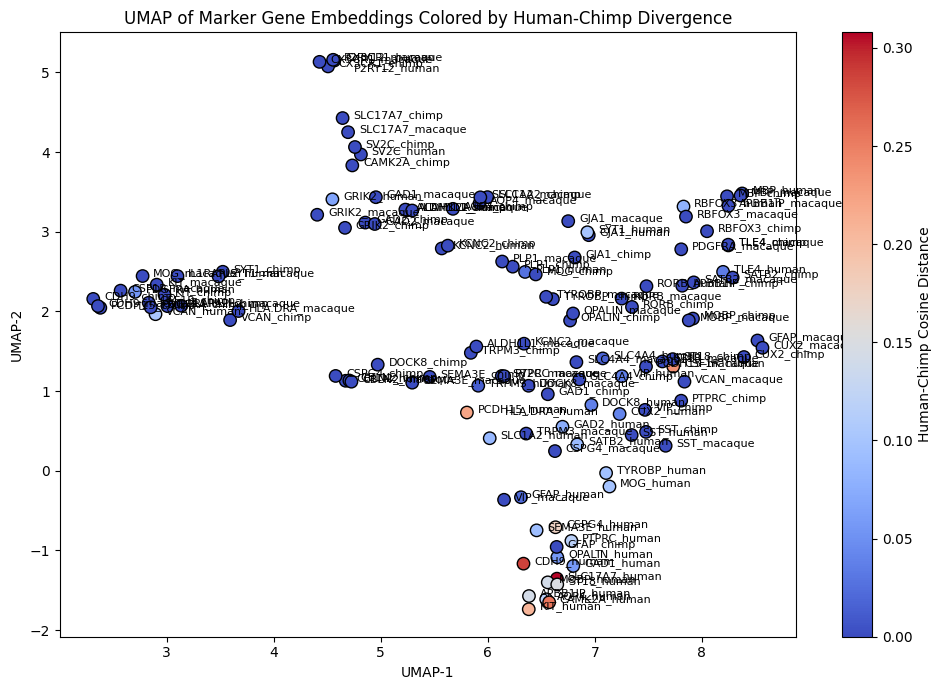

In [9]:
# === 5. UMAP Visualization for all embeddings with divergence shading ===
combined_embeddings = []
combined_labels = []
combined_divergence = []
for sp, emb_dict in all_embeddings.items():
    for gene, emb in emb_dict.items():
        combined_embeddings.append(emb)
        combined_labels.append(f"{gene}_{sp}")
        # Assign divergence score only for human embeddings using Human-Chimp as default
        if sp == "human":
            score = df_diff.loc[df_diff["Gene"] == gene, "Human-Chimp"].values[0] if gene in df_diff["Gene"].values else None
        else:
            score = None
        combined_divergence.append(score)

embedding_2d = umap.UMAP().fit_transform(np.stack(combined_embeddings))

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding_2d[:, 0], embedding_2d[:, 1],
    c=[v if v is not None else 0 for v in combined_divergence],
    cmap="coolwarm", s=80, edgecolor='k')
plt.colorbar(scatter, label="Human-Chimp Cosine Distance")
for label, (x, y) in zip(combined_labels, embedding_2d):
    plt.text(x+0.1, y, label, fontsize=8)
plt.title("UMAP of Marker Gene Embeddings Colored by Human-Chimp Divergence")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


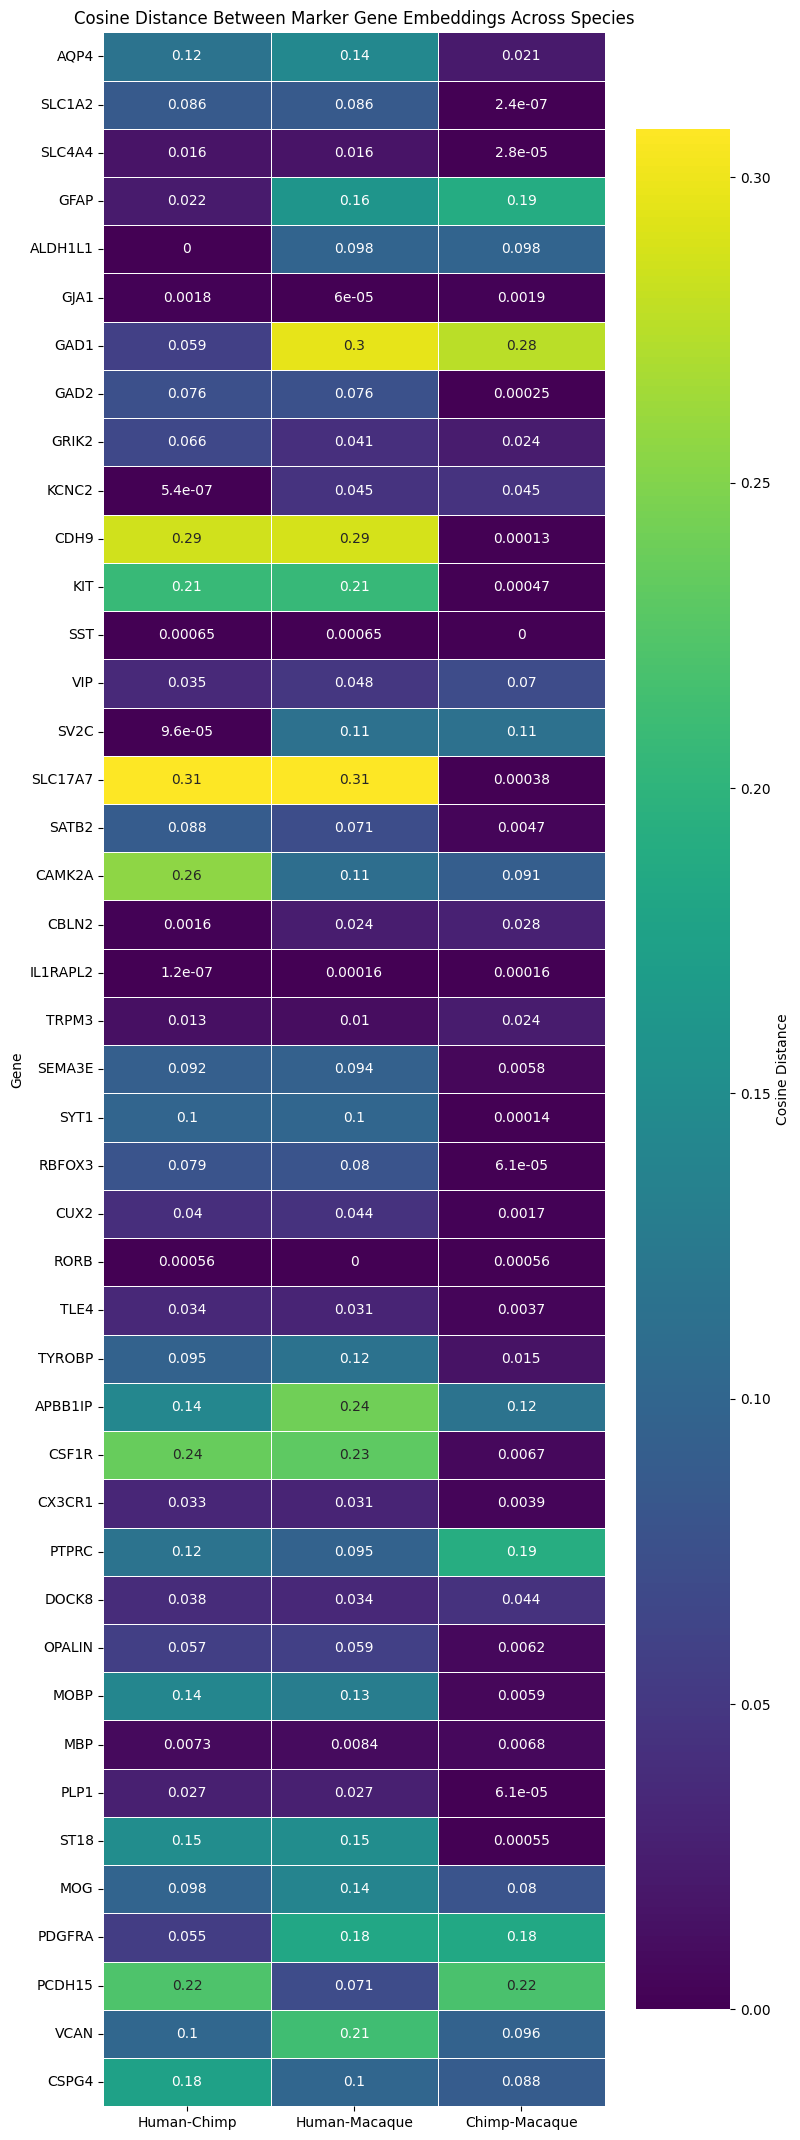

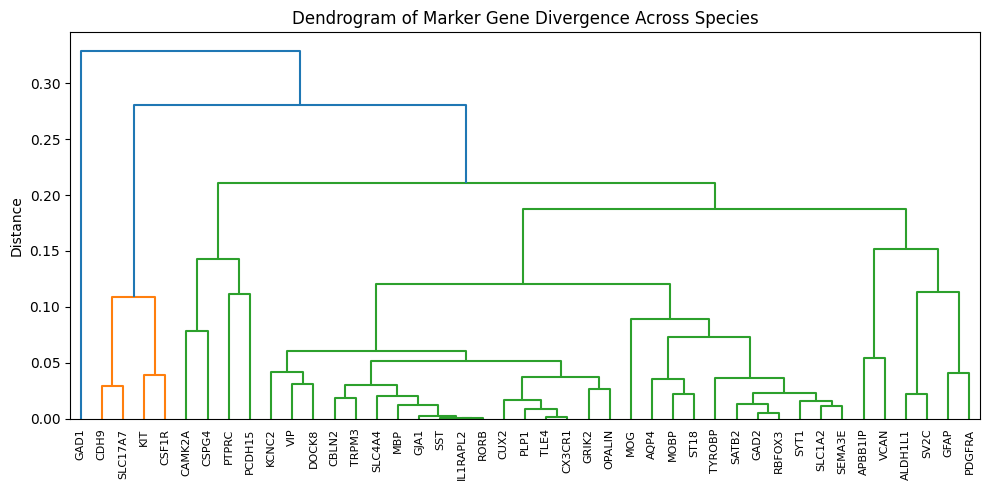

In [10]:
# === 6. Heatmap of Cosine Distances ===
heatmap_df = df_diff.set_index("Gene").dropna()
plt.figure(figsize=(8, len(heatmap_df) * 0.5))  # Adjust cell height
sns.heatmap(heatmap_df, annot=True, cmap="viridis", linewidths=0.5, cbar_kws={'label': 'Cosine Distance'})
plt.title("Cosine Distance Between Marker Gene Embeddings Across Species")
plt.tight_layout()
plt.show()

# === 7. Dendrogram for hierarchical clustering ===
linkage_matrix = linkage(heatmap_df, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=heatmap_df.index.tolist(), leaf_rotation=90)
plt.title("Dendrogram of Marker Gene Divergence Across Species")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [14]:

df_diff[(df_diff['Human-Macaque'] > 0.1) & (df_diff['Human-Chimp'] > 0.1) & (df_diff['Chimp-Macaque'] < 0.05)]


,Gene,Human-Chimp,Human-Macaque,Chimp-Macaque
0,AQP4,0.117005,0.143929,0.021109
10,CDH9,0.285700,0.287909,0.000128
11,KIT,0.207581,0.205860,0.000471
15,SLC17A7,0.307917,0.307559,0.000384
30,CSF1R,0.236122,0.231797,0.006651
36,MOBP,0.141615,0.129047,0.005906
39,ST18,0.149470,0.149449,0.000553


In [15]:

#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))


jobname test_a5e17
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length 59


In [16]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")


installing colabfold...
CPU times: user 95.6 ms, sys: 15.2 ms, total: 111 ms
Wall time: 31.4 s


In [17]:

#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)


In [18]:

#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.


2025-04-01 18:33:34,827 Running on GPU
2025-04-01 18:33:35,086 Found 5 citations for tools or databases
2025-04-01 18:33:35,087 Query 1/1: test_a5e17 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


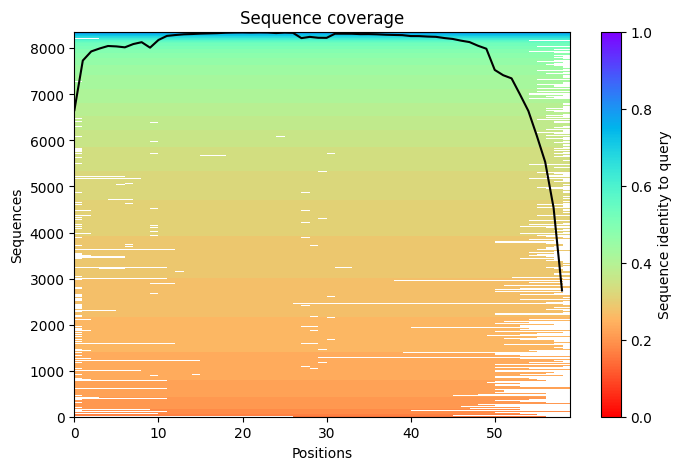

2025-04-01 18:33:38,043 Setting max_seq=512, max_extra_seq=5120
2025-04-01 18:34:50,639 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.5 pTM=0.752
2025-04-01 18:34:51,576 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=96.4 pTM=0.756 tol=0.261
2025-04-01 18:34:52,512 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=96.1 pTM=0.756 tol=0.0442
2025-04-01 18:34:53,449 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=95.9 pTM=0.755 tol=0.0542
2025-04-01 18:34:53,450 alphafold2_ptm_model_1_seed_000 took 62.0s (3 recycles)


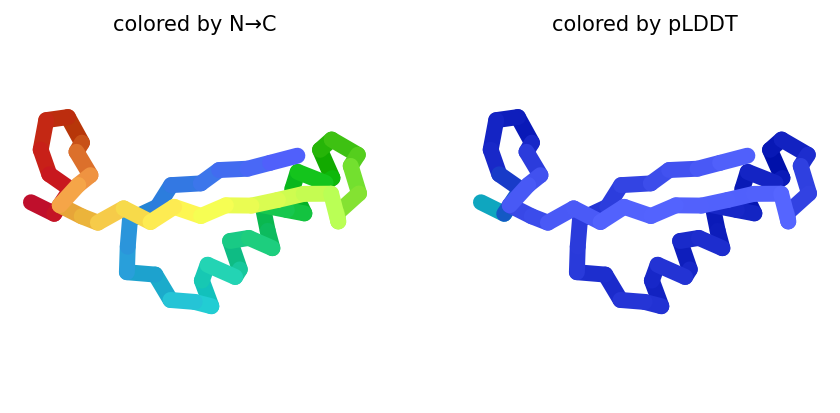

2025-04-01 18:34:54,484 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=96.9 pTM=0.758
2025-04-01 18:34:55,422 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=96.9 pTM=0.766 tol=0.316
2025-04-01 18:34:56,359 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=96.9 pTM=0.767 tol=0.135
2025-04-01 18:34:57,300 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=96.8 pTM=0.766 tol=0.0999
2025-04-01 18:34:57,301 alphafold2_ptm_model_2_seed_000 took 3.8s (3 recycles)


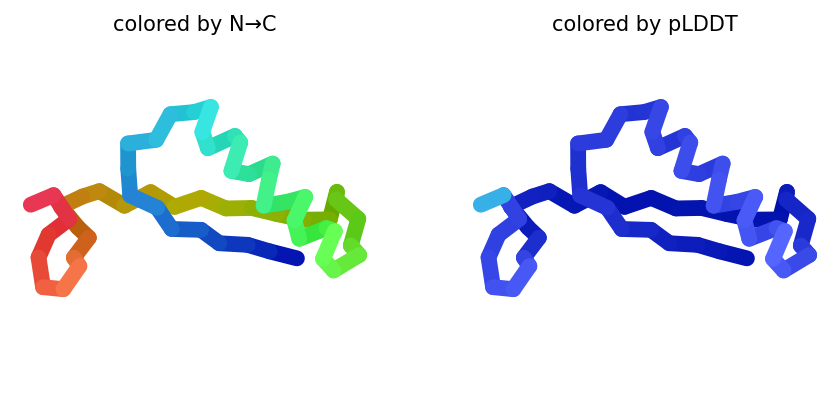

2025-04-01 18:34:58,325 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.1 pTM=0.773
2025-04-01 18:34:59,264 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.4 pTM=0.781 tol=0.254
2025-04-01 18:35:00,201 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=97.4 pTM=0.782 tol=0.113
2025-04-01 18:35:01,140 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=97.3 pTM=0.783 tol=0.0461
2025-04-01 18:35:01,141 alphafold2_ptm_model_3_seed_000 took 3.8s (3 recycles)


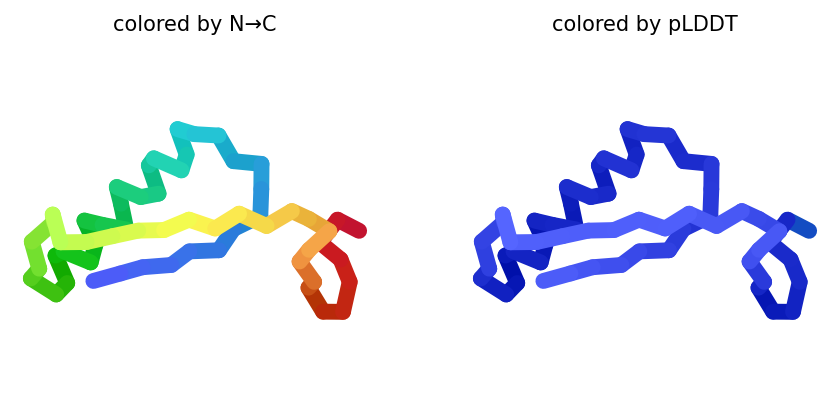

2025-04-01 18:35:02,159 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.3 pTM=0.772
2025-04-01 18:35:03,097 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.3 pTM=0.781 tol=0.241
2025-04-01 18:35:04,036 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=97.2 pTM=0.779 tol=0.0724
2025-04-01 18:35:04,975 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=96.9 pTM=0.777 tol=0.052
2025-04-01 18:35:04,976 alphafold2_ptm_model_4_seed_000 took 3.8s (3 recycles)


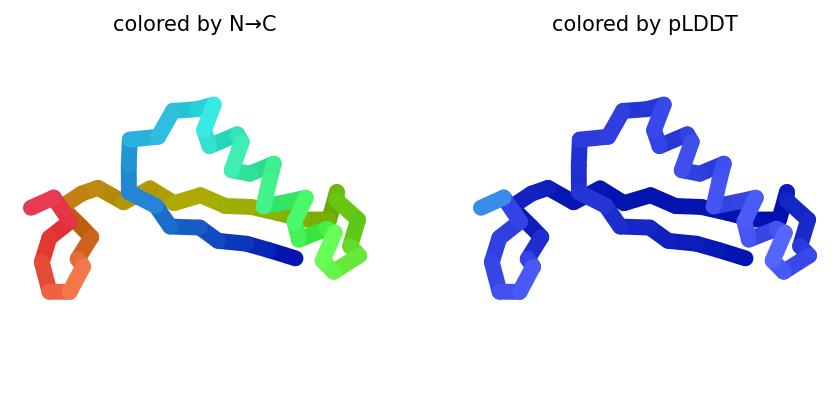

2025-04-01 18:35:05,990 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=97.3 pTM=0.782
2025-04-01 18:35:06,929 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=96.9 pTM=0.784 tol=0.203
2025-04-01 18:35:07,866 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.1 pTM=0.776 tol=0.205
2025-04-01 18:35:08,805 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=96.2 pTM=0.776 tol=0.09
2025-04-01 18:35:08,806 alphafold2_ptm_model_5_seed_000 took 3.8s (3 recycles)


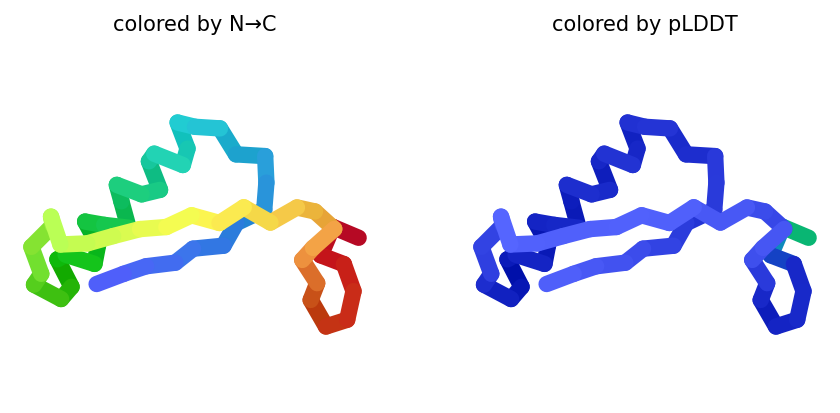

2025-04-01 18:35:08,887 reranking models by 'plddt' metric
2025-04-01 18:35:08,887 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=97.3 pTM=0.783
2025-04-01 18:35:08,887 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=96.9 pTM=0.777
2025-04-01 18:35:08,888 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=96.8 pTM=0.766
2025-04-01 18:35:08,888 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=96.2 pTM=0.776
2025-04-01 18:35:08,888 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=95.9 pTM=0.755
2025-04-01 18:35:09,861 Done


0

In [19]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

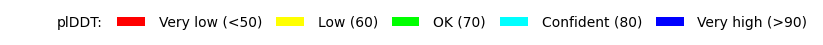

In [20]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


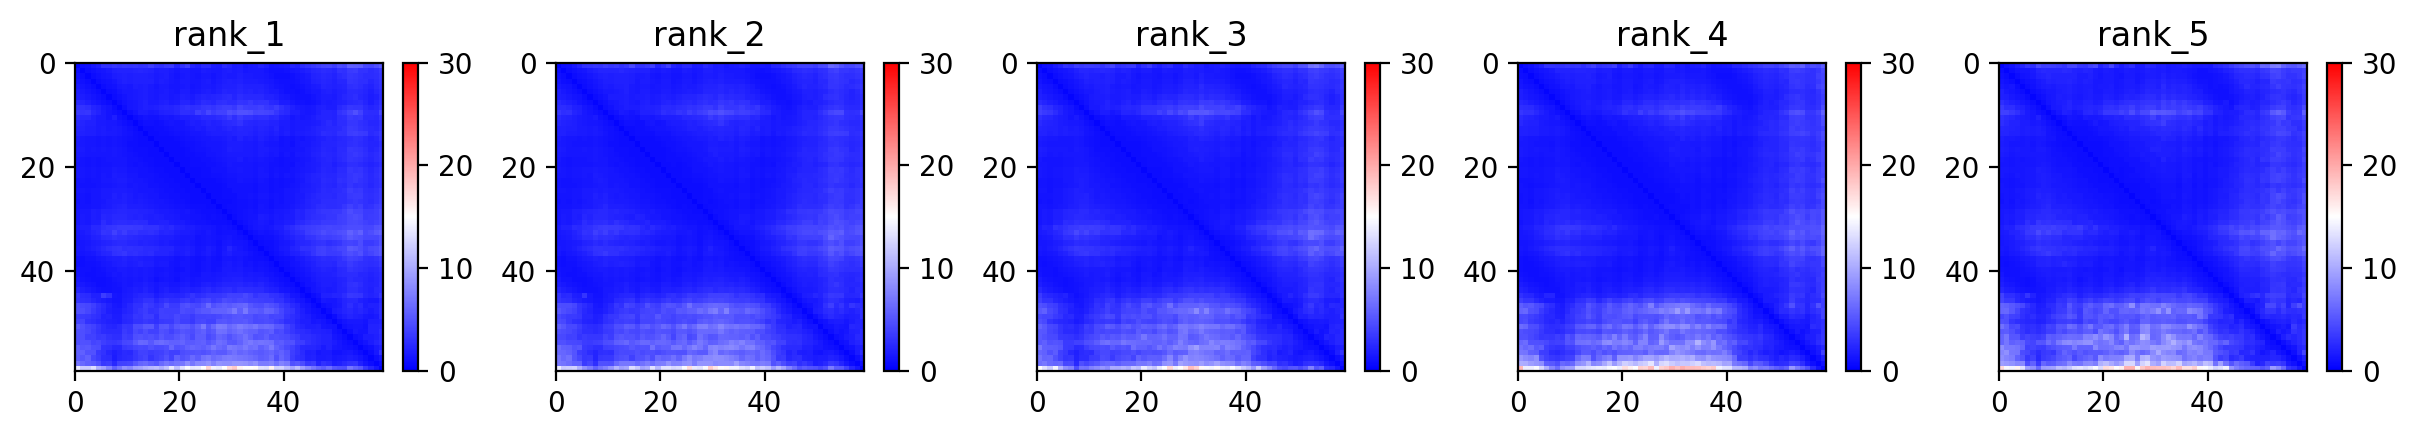
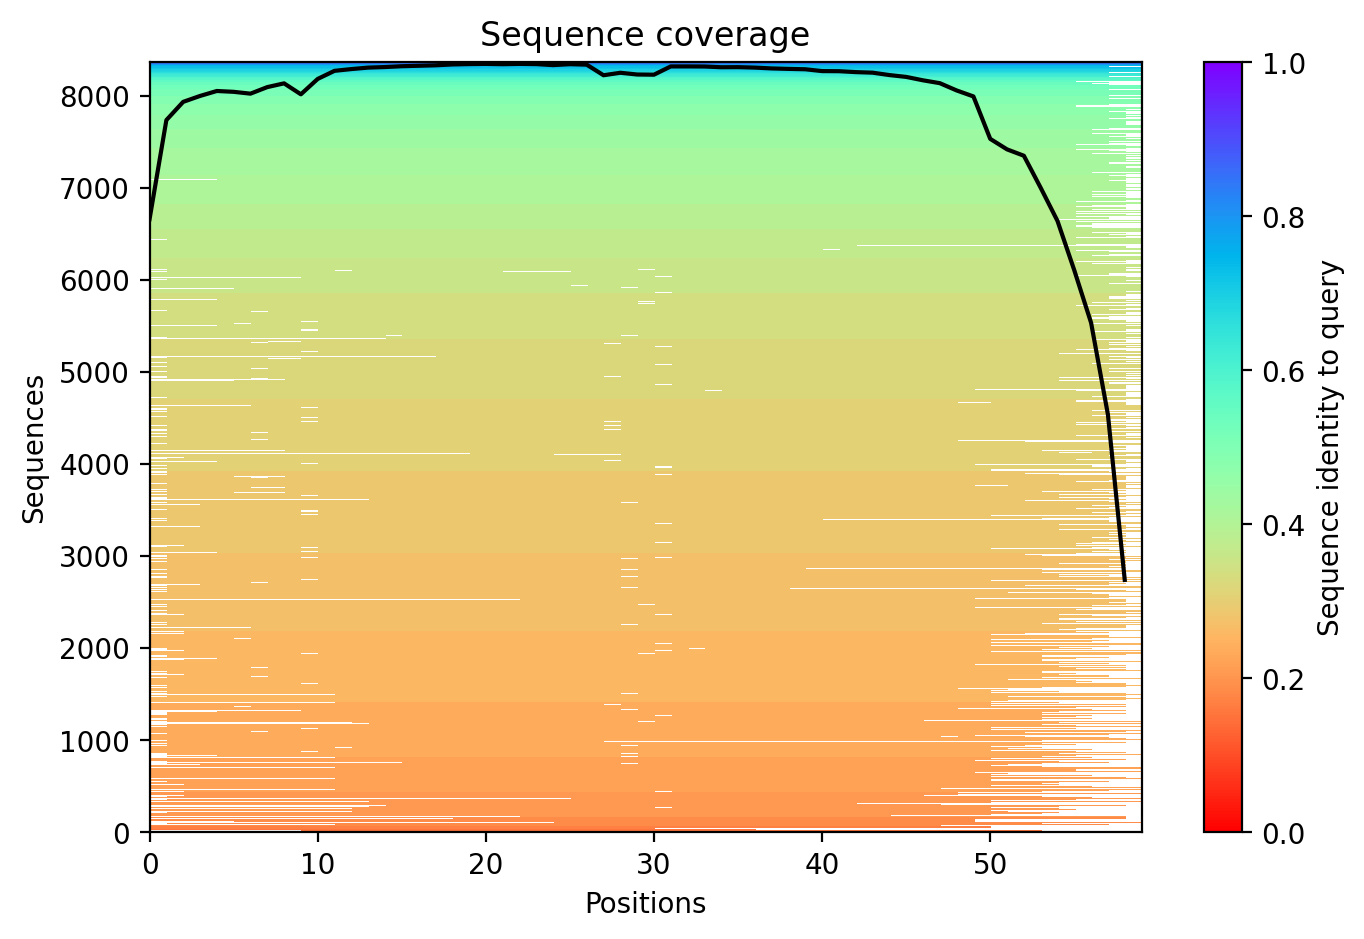
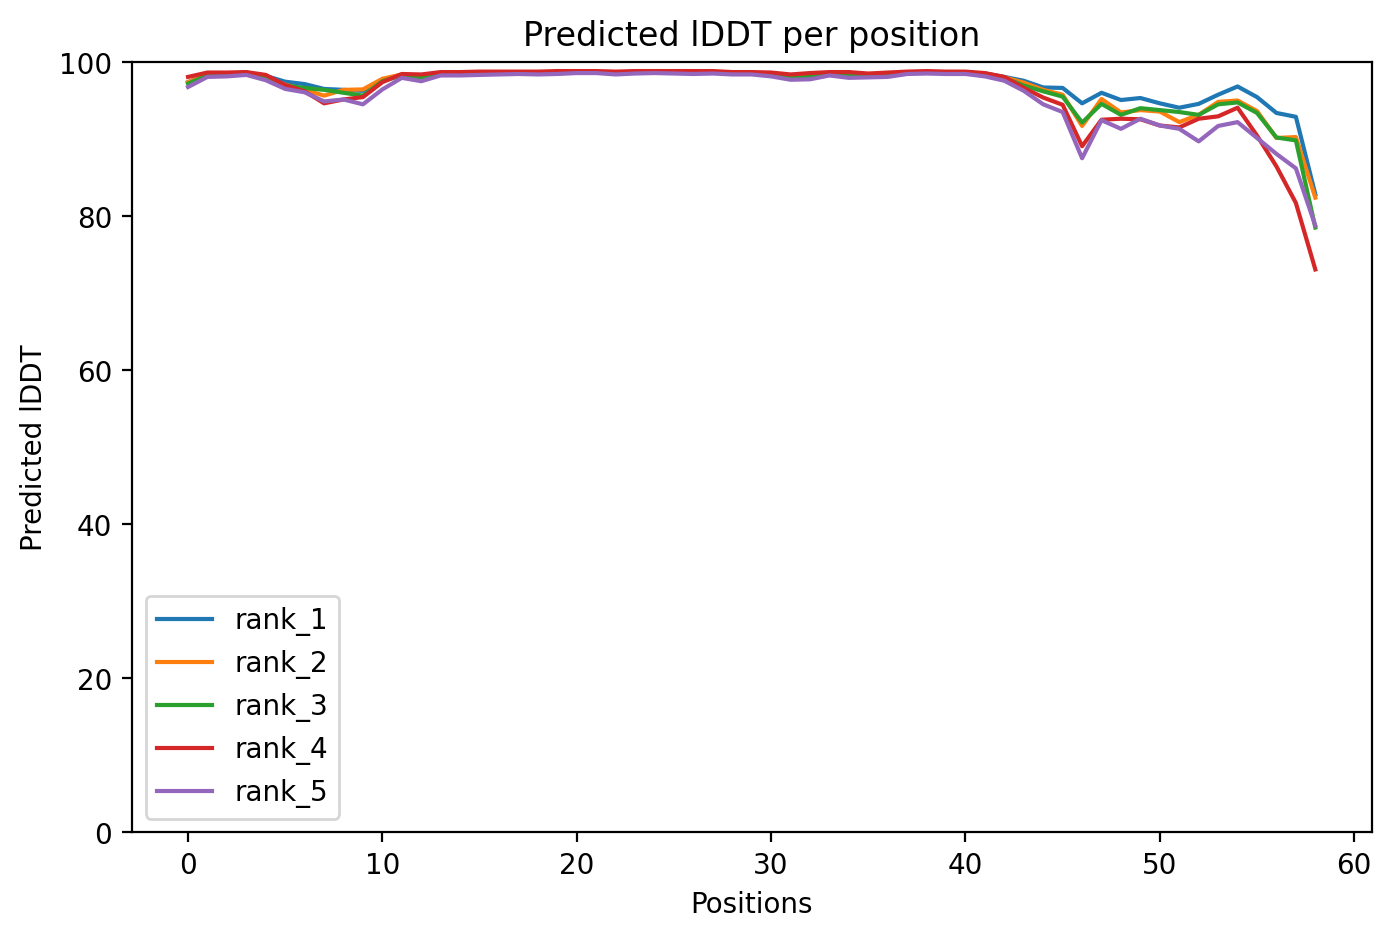

In [21]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [22]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>